In [1]:
import json
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation,TimeDistributed
from keras.layers import Bidirectional, LSTM
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate,BatchNormalization,MaxPooling1D, Convolution1D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D, RepeatVector, Permute, merge
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *
from keras.utils import to_categorical


Using TensorFlow backend.


In [2]:
import keras
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)

keras.backend.tensorflow_backend._get_available_gpus()

[]

In [3]:
#google word2vec
# from gensim.models import KeyedVectors as wv
# word_vectors = wv.load_word2vec_format('./input/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary = True)
# EMBEDDING_DIM =300

#glove
word_vectors = {}
f = open('/home/samarth/embeddings/glove.840B.300d/glove.840B.300d.txt')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    word_vectors[word] = coefs
f.close()
EMBEDDING_DIM =300

In [4]:
# texts = []
# titles =[]
# labels =[]
# for label in ['fake','real']:
#     for typ in ['gossipcop','politifact']:
#         path = './../datasets/FakeNewsNet/code/fakenewsnet_dataset/'+typ+'/'+label+'/*/news content.json'
#         files = glob.glob(path)
#         for name in tqdm(files):
#             with open(name) as json_file:
#                 data = json.load(json_file)
#                 if label == 'fake': 
#                     labels.append(1)
#                 else:
#                     labels.append(0)
#                 texts.append(' '.join(word_tokenize(data['text'])))
#     #             titles.append(' '.join(word_tokenize(data['title'])))

# df = pd.DataFrame()
# # df['title'] = title
# df['text'] = texts
# df['label'] = labels
# df.to_pickle('./pickles/text.p')

In [5]:
df = pd.read_pickle('./pickles/text.p')

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2,random_state=1)
print("Train shape : ",df_train.shape)
print("Test shape : ",df_test.shape)

Train shape :  (17802, 2)
Test shape :  (4451, 2)


In [7]:
# df_train_pos = df_train[df_train['label']==1]
# df_train_neg = df_train[df_train['label']==0].sample(len(df_train_pos)*2,random_state=1)
# df_train = pd.concat([df_train_pos,df_train_neg])
# df_train = df_train.sample(frac=1,random_state=1)
# print("Train shape : ",df_train.shape)

df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

MAX_SEQUENCE_LENGTH=4000


tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(df_train['text'])
sequences = tokenizer.texts_to_sequences(df_train['text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
train_Y = df_train['label']

sequences = tokenizer.texts_to_sequences(df_test['text'])
test_X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
test_Y = df_test['label']

/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/samarth/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Found 147878 unique tokens.


3658.860914503988
2032.0
7162.067879495823
110958


(array([1.6841e+04, 5.7400e+02, 2.0000e+02, 6.5000e+01, 4.7000e+01,
        2.7000e+01, 1.1000e+01, 1.4000e+01, 1.3000e+01, 1.0000e+01]),
 array([     0. ,  11095.8,  22191.6,  33287.4,  44383.2,  55479. ,
         66574.8,  77670.6,  88766.4,  99862.2, 110958. ]),
 <a list of 10 Patch objects>)

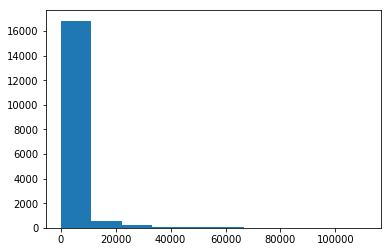

In [8]:

lengths = []
for sent in df_train['text']:
#     print(sent)
    lengths.append(len(sent.split(' ')))
#     if max(sent)>50:
#         print(sent)
print(np.mean(lengths))
print(np.median(lengths))
print(np.std(lengths))
print(np.max(lengths))
plt.hist(lengths,density=False)

In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
        word_vector = word_vectors[word]
#     if word_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = word_vector
    except KeyError:
        continue

print(train_X.shape)
print(train_Y.shape)

(17802, 4000)
(17802,)


In [15]:
def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    # So we only measure F1 on the target y value:
    y_true = y_true[:, 0]
    y_pred = y_pred[:, 0]
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [16]:
# model = Sequential()
dropout_prob = [0.2,0.2]
hidden_dims = 50
filter_sizes  = (3,8)
num_filters = 10
BATCH_SIZE = 32

input_shape = (MAX_SEQUENCE_LENGTH,)
model_input = Input(shape=input_shape)

z = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)(model_input)

conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy",f1])

print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 4000)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 4000, 300)    44363700    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 3998, 10)     9010        embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 3993, 10)     24010       embedding_2[0][0]                
____________________________________________________________________________________________

In [17]:
history = model.fit(train_X, train_Y, epochs=10,batch_size=BATCH_SIZE,validation_split=0.1)

Train on 16021 samples, validate on 1781 samples
Epoch 1/10
16021/16021 [==============================] - 15s 964us/step - loss: 0.4769 - accuracy: 0.7826 - f1: 0.1832 - val_loss: 0.4116 - val_accuracy: 0.8428 - val_f1: 0.5108
Epoch 2/10
16021/16021 [==============================] - 14s 880us/step - loss: 0.3590 - accuracy: 0.8453 - f1: 0.5840 - val_loss: 0.3846 - val_accuracy: 0.8557 - val_f1: 0.6004
Epoch 3/10
16021/16021 [==============================] - 14s 897us/step - loss: 0.2650 - accuracy: 0.8854 - f1: 0.7160 - val_loss: 0.4195 - val_accuracy: 0.8433 - val_f1: 0.6114
Epoch 4/10
16021/16021 [==============================] - 15s 923us/step - loss: 0.1888 - accuracy: 0.9212 - f1: 0.8164 - val_loss: 0.5448 - val_accuracy: 0.8473 - val_f1: 0.5725
Epoch 5/10
16021/16021 [==============================] - 15s 927us/step - loss: 0.1432 - accuracy: 0.9411 - f1: 0.8647 - val_loss: 0.6072 - val_accuracy: 0.8389 - val_f1: 0.5705
Epoch 6/10
16021/16021 [==============================] 

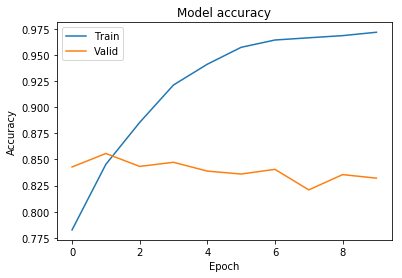

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [19]:

probs= model.predict(test_X,verbose=1,batch_size=50)
preds = [0]*len(probs)
# print(preds.shape)
# print(test_Y.shape)
# preds[probs[:,0]>=0.5] =1 
print(metrics.f1_score(test_Y, probs>=0.5))

4451/4451 [==============================] - 2s 417us/step
0.6041666666666667


In [17]:
# metrics.f1_score(test_Y, (probs>thresh).astype(int)))